In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import random

import sys
sys.path.append("..")
from settings import WUS_LOCAL, WUS_CLUSTER, AMBIGUITY_PATH
from src.analysis.entropy import get_emoji_entropy
from src.data.utils import apply_contains_emoji, find_emojis, flatten
from src.visualization.emoji_plotting import get_emojis_per_bin

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})
pd.set_option('mode.chained_assignment', None)

random.seed(7)
cluster = False

In [2]:
WUS_DATA_PATH = WUS_LOCAL
NUM_CPUS = 4
if cluster:
    WUS_DATA_PATH = WUS_CLUSTER
    NUM_CPUS = 8

In [3]:
emojis = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')

### Entropy and perplexity for ambiguity dataset

In [4]:
vocabularies = emojis.groupby("emoji")["word"].apply(list)
bow = vocabularies.apply(Counter)
bow['😂']

Counter({'lol': 2,
         'laugh': 5,
         'laugher': 1,
         'funny': 3,
         'laughing': 6,
         'laughingsohardimcrying': 1,
         'cry': 2,
         'joy': 1,
         'happy sad': 1,
         'crying': 5,
         'liao': 1})

In [5]:
bow = bow.to_frame()
bow["entropy"] = bow.word.apply(get_emoji_entropy)
bow.entropy.describe()

count    1325.000000
mean        1.410624
std         0.713803
min         0.000000
25%         0.870199
50%         1.382607
75%         1.935850
max         3.198917
Name: entropy, dtype: float64

In [6]:
bow.entropy.sort_values(ascending=False)[:20]

emoji
🈁      3.198917
💁      3.144580
♍      3.084962
🚠      3.084652
🎍      3.065965
🗯️     3.044390
🎑      3.042476
🙇      3.031519
🔁      3.014636
➿      3.014077
🤟      2.984870
⛎      2.966827
🙄      2.966827
👩‍💼    2.950426
🛃      2.948256
🦳      2.946397
😬      2.921658
🍘      2.918058
🤙      2.917433
🛂      2.900980
Name: entropy, dtype: float64

In [7]:
bow["perplexity"] = bow.entropy.apply(np.exp)
bow.perplexity.sort_values(ascending=False)[:20]

emoji
🈁      24.505964
💁      23.209930
♍      21.866638
🚠      21.859857
🎍      21.455146
🗯️     20.997224
🎑      20.957066
🙇      20.728693
🔁      20.381664
➿      20.370286
🤟      19.783926
⛎      19.430165
🙄      19.430165
👩‍💼    19.114092
🛃      19.072663
🦳      19.037235
😬      18.572048
🍘      18.505306
🤙      18.493753
🛂      18.191973
Name: perplexity, dtype: float64

In [8]:
vocabularies = emojis.groupby("emoji")["word"].apply(set)
vocabularies = vocabularies.reset_index().rename({"word": "vocabulary"}, axis=1)
vocabularies["simple_ambiguity"] = vocabularies.vocabulary.apply(len) / vocabularies.vocabulary.apply(len).max()
vocabularies.head()

,emoji,vocabulary,simple_ambiguity
0,#️⃣,"{tag, hashtag, doubtful, number, pound, ash}",0.230769
1,*️⃣,"{snowflake, asterisk, astrid, hospital, number...",0.307692
2,©️,"{contact, c, clear, corporation, fee, call, co...",0.346154
3,®️,"{right, circle r, reserved, railroad, r, restr...",0.615385
4,‼️,"{attention, alert, urgent, excited, angry, imp...",0.461538


In [9]:
vocabularies["size"] = vocabularies.vocabulary.apply(len)
vocabularies.describe()

,simple_ambiguity,size
count,1325.000000,1325.000000
mean,0.318200,8.273208
std,0.177015,4.602401
min,0.038462,1.000000
25%,0.192308,5.000000
50%,0.269231,7.000000
75%,0.423077,11.000000
max,1.000000,26.000000


### Simple ambiguity in WUS

In [10]:
messages = pd.read_csv(WUS_DATA_PATH, encoding='utf-8', low_memory=False)
messages.timestamp = pd.to_datetime(messages.timestamp)
msgs = messages[["chat", "msg_id", "spk", "timestamp", "most_likely_lang", "msg", "msg_tokens"]]
msgs = msgs.set_index("timestamp")
emojis_msgs = msgs[apply_contains_emoji(msgs.msg)]
emojis_msgs["emojis"] = emojis_msgs.msg.apply(find_emojis)

In [11]:
emojis_msgs.head()

,chat,msg_id,spk,most_likely_lang,msg,msg_tokens,emojis
timestamp,,,,,,,
2013-08-21 16:30:08+00:00,chat427,473746,spk1292,gsw,Chunnsch hüt hai? 😘,5,[😘]
2013-09-17 12:54:27+00:00,chat427,473772,spk1292,gsw,Und wia gouts em Bindli vor dr groussa Party? ...,12,"[😍, 😘]"
2013-09-17 13:55:06+00:00,chat427,473773,spk1291,gsw,Joo sichr riiseparty gits 🎊 🎉 🎁 🍻 ...niicht...,22,"[🎊, 🎉, 🎁, 🍻, 😜]"
2013-09-17 19:04:47+00:00,chat427,473774,spk1292,gsw,"Duuuu, bisch du am Fritig Mittag au dou bi üs?...",26,"[😃, 😳, 🐄, 🐄, 🐄, 🐙, 🐌, 🐢, 🚣, 🚀, ✈]"
2013-09-17 19:17:02+00:00,chat427,473775,spk1292,gsw,PS: volkhard au dou... 🚂,7,[🚂]


In [12]:
emoji_counts = Counter(flatten(emojis_msgs.emojis.values))
wus_vocabs = vocabularies[vocabularies.emoji.isin(list(emoji_counts.keys()))]
emoji_counts = pd.DataFrame.from_dict({"emoji": list(emoji_counts.keys()), "count": list(emoji_counts.values())})
emoji_counts.sort_values("count", ascending=False)[:10]

,emoji,count
48,😂,28690
47,❤,18908
0,😘,17500
104,😁,11886
38,😄,10441
45,😉,9706
42,😊,8691
6,😜,5656
1,😍,5202
20,💋,4565


In [13]:
wus_vocabs = wus_vocabs.set_index("emoji").join(emoji_counts.set_index("emoji"))
wus_vocabs = wus_vocabs.rename({"count": "wus_count"}, axis=1)
wus_vocabs["wus_frequency"] = wus_vocabs.wus_count / wus_vocabs.wus_count.sum()
wus_vocabs["vocab_length"] = wus_vocabs.vocabulary.apply(len)
wus_vocabs["entropy"] = bow["entropy"]
wus_vocabs["perplexity"] = bow["perplexity"]
wus_vocabs.head()

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
⌚,"{timing, watch, time}",0.115385,3,8,0.000045,3,0.638967,1.894522
⏩,"{next, arrow, play, backward, forward, fastfor...",0.269231,7,1,0.000006,7,1.287205,3.622648
⏰,"{clock, alarm, alarmclock, time}",0.153846,4,11,0.000062,4,1.252713,3.499825
◽,"{white, grey, square, marshmallow, empty box, ...",0.384615,10,3,0.000017,10,1.888749,6.611096
☔,"{umbrella, rain, rainy, raining}",0.153846,4,96,0.000538,4,1.120950,3.067768


In [14]:
wus_vocabs.corr("spearman")

,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
simple_ambiguity,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
size,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
wus_count,-0.091198,-0.091198,1.000000,1.000000,-0.091198,-0.066191,-0.066191
wus_frequency,-0.091198,-0.091198,1.000000,1.000000,-0.091198,-0.066191,-0.066191
vocab_length,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
entropy,0.951000,0.951000,-0.066191,-0.066191,0.951000,1.000000,1.000000
perplexity,0.951000,0.951000,-0.066191,-0.066191,0.951000,1.000000,1.000000


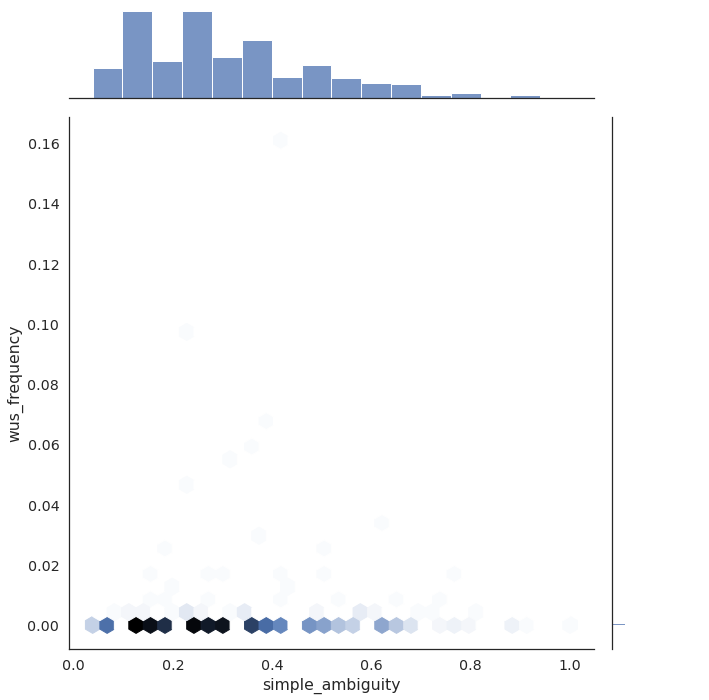

In [15]:
sns.jointplot(data=wus_vocabs, x='simple_ambiguity', y='wus_frequency', kind='hex',height=10);

In [16]:
wus_vocabs[wus_vocabs.simple_ambiguity == wus_vocabs.simple_ambiguity.max()]

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
💁,"{give, action, server, person, raise, boy, con...",1.0,26,482,0.0027,26,3.14458,23.20993


In [17]:
wus_vocabs[wus_vocabs.wus_frequency == wus_vocabs.wus_frequency.max()]

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
😂,"{laughingsohardimcrying, funny, laugh, laughin...",0.423077,11,28690,0.160729,11,2.156727,8.642806


In [18]:
wus_vocabs.simple_ambiguity.sort_values(ascending=False)[:20]

emoji
💁    1.000000
🚠    0.923077
🙇    0.884615
🎑    0.884615
🎍    0.884615
😬    0.807692
🛃    0.807692
🎇    0.807692
💢    0.769231
🍘    0.769231
🈸    0.769231
😏    0.769231
😝    0.730769
📟    0.730769
😕    0.730769
🙍    0.730769
🙆    0.692308
🍙    0.692308
🚏    0.692308
😖    0.692308
Name: simple_ambiguity, dtype: float64

In [19]:
wus_vocabs["mean_duration"] = emojis.groupby("emoji").Duration.sum() / emojis.groupby("emoji").WorkerID.count()

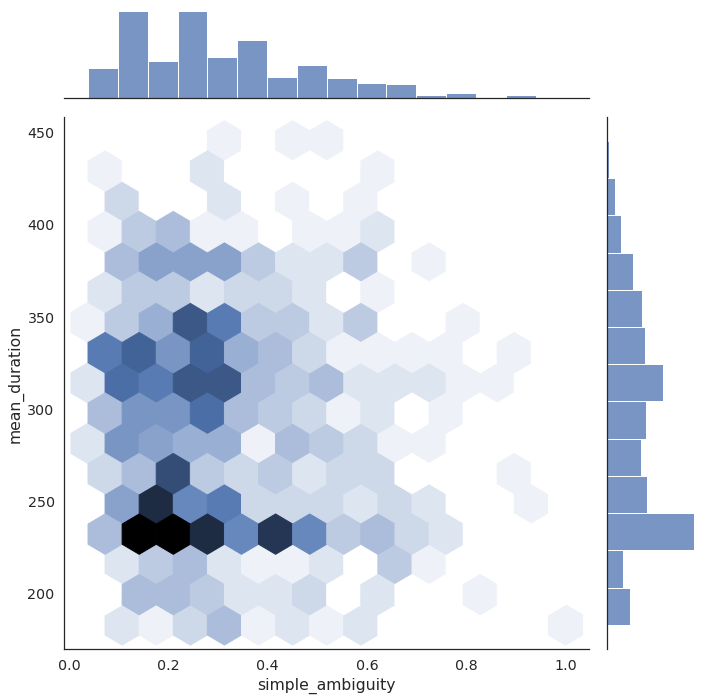

In [20]:
sns.jointplot(data=wus_vocabs, x='simple_ambiguity', y='mean_duration', kind='hex', height=10);

In [21]:
emoji_counts = Counter(flatten(emojis_msgs.emojis.values))
wus_vocabs = vocabularies[vocabularies.emoji.isin(list(emoji_counts.keys()))]
emoji_counts = pd.DataFrame.from_dict({"emoji": list(emoji_counts.keys()), "count": list(emoji_counts.values())})
emoji_counts.sort_values("count", ascending=False)[:10]

,emoji,count
48,😂,28690
47,❤,18908
0,😘,17500
104,😁,11886
38,😄,10441
45,😉,9706
42,😊,8691
6,😜,5656
1,😍,5202
20,💋,4565


### Entropy in WUS

In [22]:
wus_vocabs = wus_vocabs.set_index("emoji").join(emoji_counts.set_index("emoji"))
wus_vocabs = wus_vocabs.rename({"count": "wus_count"}, axis=1)
wus_vocabs["wus_frequency"] = wus_vocabs.wus_count / wus_vocabs.wus_count.sum()
wus_vocabs["vocab_length"] = wus_vocabs.vocabulary.apply(len)
wus_vocabs["entropy"] = bow["entropy"]
wus_vocabs["perplexity"] = bow["perplexity"]
wus_vocabs.head()

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
⌚,"{timing, watch, time}",0.115385,3,8,0.000045,3,0.638967,1.894522
⏩,"{next, arrow, play, backward, forward, fastfor...",0.269231,7,1,0.000006,7,1.287205,3.622648
⏰,"{clock, alarm, alarmclock, time}",0.153846,4,11,0.000062,4,1.252713,3.499825
◽,"{white, grey, square, marshmallow, empty box, ...",0.384615,10,3,0.000017,10,1.888749,6.611096
☔,"{umbrella, rain, rainy, raining}",0.153846,4,96,0.000538,4,1.120950,3.067768


In [23]:
wus_vocabs.corr("spearman")

,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
simple_ambiguity,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
size,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
wus_count,-0.091198,-0.091198,1.000000,1.000000,-0.091198,-0.066191,-0.066191
wus_frequency,-0.091198,-0.091198,1.000000,1.000000,-0.091198,-0.066191,-0.066191
vocab_length,1.000000,1.000000,-0.091198,-0.091198,1.000000,0.951000,0.951000
entropy,0.951000,0.951000,-0.066191,-0.066191,0.951000,1.000000,1.000000
perplexity,0.951000,0.951000,-0.066191,-0.066191,0.951000,1.000000,1.000000


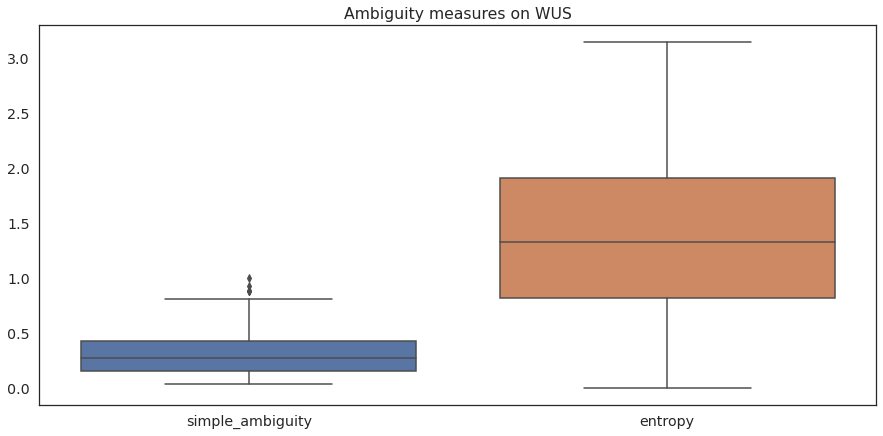

In [24]:
sns.boxplot(data=wus_vocabs[["simple_ambiguity", "entropy"]]).set_title("Ambiguity measures on WUS");

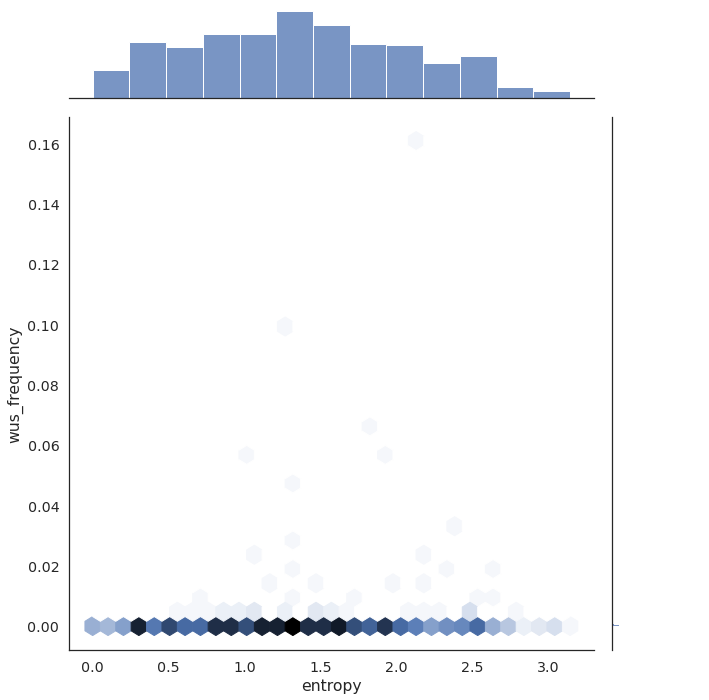

In [25]:
sns.jointplot(data=wus_vocabs, x='entropy', y='wus_frequency', kind='hex', height=10);

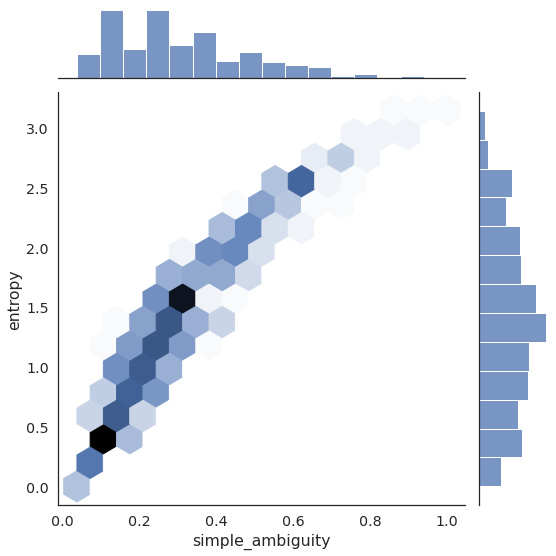

In [26]:
sns.jointplot(data=wus_vocabs, x='simple_ambiguity', y='entropy', kind='hex', height=8);

In [27]:
wus_vocabs[wus_vocabs.simple_ambiguity == wus_vocabs.simple_ambiguity.max()]

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
💁,"{give, action, server, person, raise, boy, con...",1.0,26,482,0.0027,26,3.14458,23.20993


In [28]:
wus_vocabs[wus_vocabs.wus_frequency == wus_vocabs.wus_frequency.max()]

,vocabulary,simple_ambiguity,size,wus_count,wus_frequency,vocab_length,entropy,perplexity
emoji,,,,,,,,
😂,"{laughingsohardimcrying, funny, laugh, laughin...",0.423077,11,28690,0.160729,11,2.156727,8.642806


In [29]:
wus_vocabs.simple_ambiguity.sort_values(ascending=False)[:20]

emoji
💁    1.000000
🚠    0.923077
🙇    0.884615
🎑    0.884615
🎍    0.884615
😬    0.807692
🛃    0.807692
🎇    0.807692
💢    0.769231
🍘    0.769231
🈸    0.769231
😏    0.769231
😝    0.730769
📟    0.730769
😕    0.730769
🙍    0.730769
🙆    0.692308
🍙    0.692308
🚏    0.692308
😖    0.692308
Name: simple_ambiguity, dtype: float64

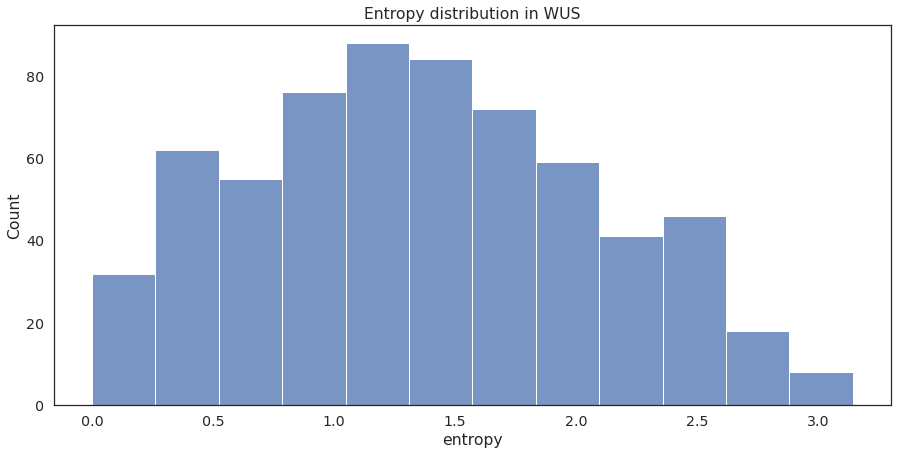

In [32]:
ax = sns.histplot(data=wus_vocabs, x="entropy", bins='doane')
ax.set_title("Entropy distribution in WUS");

In [33]:
get_emojis_per_bin(ax, wus_vocabs)

,bin,example_emojis
0,"(0.0, 0.26)","[🐋, 🌳, 🐘]"
1,"(0.26, 0.52)","[🐷, ⭐, 🆒]"
2,"(0.52, 0.79)","[🚗, 👕, 🌠]"
3,"(0.79, 1.05)","[💖, 🚶, 🌵]"
4,"(1.05, 1.31)","[💫, 🍭, ✊]"
5,"(1.31, 1.57)","[🍖, 📨, 📊]"
6,"(1.57, 1.83)","[🌴, 👿, 🍈]"
7,"(1.83, 2.1)","[💴, 👬, ❌]"
8,"(2.1, 2.36)","[🙌, 🎨, 👠]"
9,"(2.36, 2.62)","[😪, 😣, ❎]"


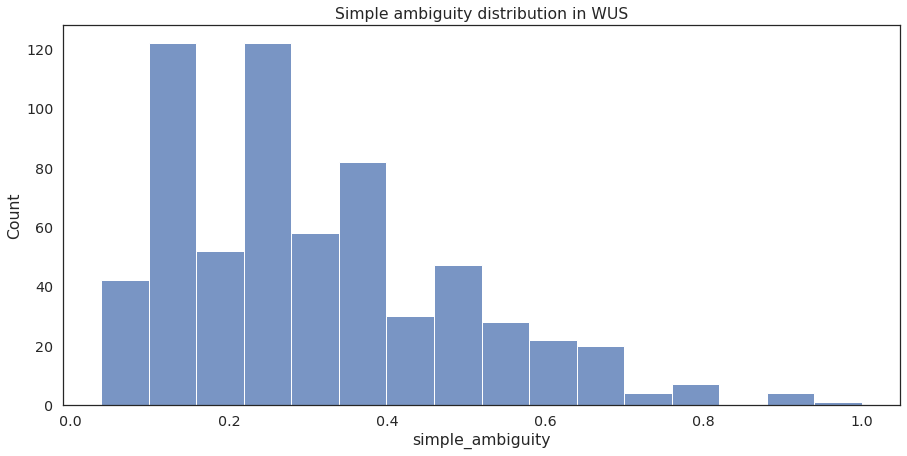

In [34]:
ax = sns.histplot(wus_vocabs.simple_ambiguity)
ax.set_title("Simple ambiguity distribution in WUS");

In [36]:
get_emojis_per_bin(ax, wus_vocabs)[2:]

,bin,example_emojis
2,"(0.16, 0.22)","[🆙, 👶]"
3,"(0.22, 0.28)","[⚾, 🐅, ⛪]"
4,"(0.28, 0.34)","[🐟, 🚂, 🐳]"
5,"(0.34, 0.4)","[🌛, 🆒, 🎼]"
6,"(0.4, 0.46)","[🔔, 🔺, 🏰]"
7,"(0.46, 0.52)","[🐶, ⛺, 📏]"
8,"(0.52, 0.58)","[🚕, 🍇, 📕]"
9,"(0.58, 0.64)","[⌚, 💗, 🍚]"
10,"(0.64, 0.7)","[🐠, 📺, 👑]"
11,"(0.7, 0.76)","[🐸, 🐤, 💛]"
